# Ensemble Methods

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

## 1. Load the Dataset

In [2]:
df = pd.read_csv('Lumos5G-v1.0.csv',
                index_col=['run_num', 'seq_num'])
df.head(5)

abstractSignalStr   latitude  longitude  movingSpeed  \
run_num seq_num                                                         
1       1.0                      2  44.975314 -93.259316     0.094889   
        2.0                      2  44.975311 -93.259311     0.876634   
        3.0                      2  44.975305 -93.259292     2.225798   
        4.0                      2  44.975293 -93.259258     3.180726   
        5.0                      2  44.975278 -93.259214     3.751234   

                 compassDirection        nrStatus  lte_rssi  lte_rsrp  \
run_num seq_num                                                         
1       1.0                   150  NOT_RESTRICTED     -61.0       -94   
        2.0                   117  NOT_RESTRICTED     -61.0       -94   
        3.0                   113  NOT_RESTRICTED     -61.0       -94   
        4.0                   114  NOT_RESTRICTED     -59.0       -95   
        5.0                   115  NOT_RESTRICTED     -59.0       -95   

                 lte_rsrq     lte_rssnr  nr_ssRsrp  nr_ssRsrq  nr_ssSinr  \
run_num seq_num                                                            
1       1.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        2.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        3.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        4.0         -16.0  2.147484e+09        NaN        NaN        NaN   
        5.0         -16.0  2.147484e+09        NaN        NaN        NaN   

                 Throughput mobility_mode trajectory_direction  tower_id  
run_num seq_num                                                           
1       1.0              78       driving                   CW        16  
        2.0             117       driving                   CW        16  
        3.0             110       driving                   CW        16  
        4.0             108       driving                   CW        16  
        5.0             100       driving                   CW        16

In [3]:
# select columns
ndf = df[["Throughput"]]
ndf.head()

Throughput
run_num seq_num            
1       1.0              78
        2.0             117
        3.0             110
        4.0             108
        5.0             100

In [4]:
max_throughput = ndf.max()
min_throughput = ndf.min()
print(f'Max throughput: {max_throughput}')
print(f'Min throughput: {min_throughput}')
max_throughput = max_throughput.item() # get python int!

Max throughput: Throughput    1920
dtype: int64
Min throughput: Throughput    0
dtype: int64


In [5]:
# Min-Max Scaling
df=(ndf-ndf.min())/(ndf.max()-ndf.min())
df.head()

Throughput
run_num seq_num            
1       1.0        0.040625
        2.0        0.060937
        3.0        0.057292
        4.0        0.056250
        5.0        0.052083

## 2. Create Train-Test Sets

In [6]:
# split function into sequences
def multistep_split(seq, n_steps_in, n_steps_out):
    X = list()
    y = list()
    for i in range(len(seq)):
        # pattern end
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(seq):
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
# separately splits runs into sequences
run_max=df.index.max()[0]
seconds_in = 20
seconds_out = 20 
X_list = list()
y_list = list()
for run_num in range(1, run_max+1):
    run = df.loc[run_num].values
    X, y = multistep_split(run.astype('float32'), n_steps_in=seconds_in, n_steps_out=seconds_out)
    X_list.append(X)
    y_list.append(y)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
X = X.reshape((X.shape[0], X.shape[1]))
print(X.shape)
print(y.shape)

(63516, 20)
(63516, 20)


In [8]:
ratio=0.7
train_size = int(ratio*X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(44461, 20)
(44461, 20)
(19055, 20)
(19055, 20)


## 3. Random Forest

In [9]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

RandomForestRegressor()

MSE of RF for this example : 0.0080


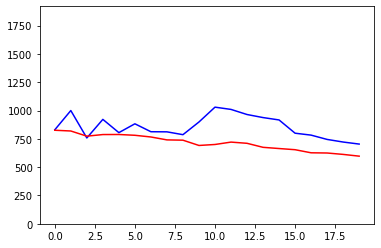

In [10]:
n = 360 # example number
y_true = y_test[n]
x = X_test[n].reshape(1,-1)
y_pred = model.predict(x).flatten()
print(f'MSE of RF for this example : {mean_squared_error(y_true, y_pred):.4f}')
plt.plot(y_true*max_throughput, 'b')
plt.plot(y_pred*max_throughput, 'r')
plt.ylim(0, max_throughput)
plt.show()

In [11]:
# MSE for all test data
mse_list = list()
for x,y in zip(X_test, y_test):
    x_in = x.reshape(1,-1)
    y_pred = model.predict(x_in).flatten()
    mse = mean_squared_error(y, y_pred)
    mse_list.append(mse)
MSE = np.array(mse_list)
MSE = MSE.mean()
print(f'RF MSE for all test data: {MSE:.4f}')
print(f'RF RMSE: {math.sqrt(MSE)*max_throughput:4f}')

RF MSE for all test data: 0.0354
RF RMSE: 361.366000


## 4. Extra Trees

In [12]:
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor()

MSE of ET for this example : 0.0095


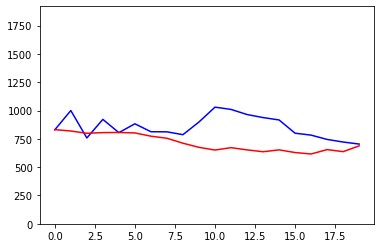

In [13]:
n = 360 # example number
y_true = y_test[n]
x = X_test[n].reshape(1,-1)
y_pred = model.predict(x).flatten()
print(f'MSE of ET for this example : {mean_squared_error(y_true, y_pred):.4f}')
plt.plot(y_true*max_throughput, 'b')
plt.plot(y_pred*max_throughput, 'r')
plt.ylim(0, max_throughput)
plt.show()

In [14]:
# MSE for all test data
mse_list = list()
for x,y in zip(X_test, y_test):
    x_in = x.reshape(1,-1)
    y_pred = model.predict(x_in).flatten()
    mse = mean_squared_error(y, y_pred)
    mse_list.append(mse)
MSE = np.array(mse_list)
MSE = MSE.mean()
print(f'ET MSE for all test data: {MSE:.4f}')
print(f'ET RMSE: {math.sqrt(MSE)*max_throughput:4f}')

ET MSE for all test data: 0.0355
ET RMSE: 361.643041


## 5. Gradient Boosting

In [15]:
model = GradientBoostingRegressor(n_estimators=30)
wrapper = MultiOutputRegressor(model)
wrapper.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=30))

MSE of GB for this example : 0.0084


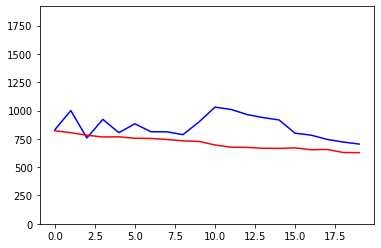

In [16]:
n = 360 # example number
y_true = y_test[n]
x = X_test[n].reshape(1,-1)
y_pred = wrapper.predict(x).flatten()
print(f'MSE of GB for this example : {mean_squared_error(y_true, y_pred):.4f}')
plt.plot(y_true*max_throughput, 'b')
plt.plot(y_pred*max_throughput, 'r')
plt.ylim(0, max_throughput)
plt.show()

In [17]:
# MSE for all test data
mse_list = list()
for x,y in zip(X_test, y_test):
    x_in = x.reshape(1,-1)
    y_pred = wrapper.predict(x_in).flatten()
    mse = mean_squared_error(y, y_pred)
    mse_list.append(mse)
MSE = np.array(mse_list)
MSE = MSE.mean()
print(f'GB MSE for all test data: {MSE:.4f}')
print(f'GB RMSE: {math.sqrt(MSE)*max_throughput:4f}')

GB MSE for all test data: 0.0347
GB RMSE: 357.414782
